In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from data_loading import load_annotated_6k_collection


pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('../../data/external/clinvar_variant_summary_2022-04-03.txt',
                 sep='\t')
sig_cats = {'Pathogenic', 
            'Likely pathogenic',
            'Pathogenic/Likely pathogenic'}
df = df.loc[(df['Assembly'] == 'GRCh38') &
            df['ClinicalSignificance'].apply(lambda x: any(y in sig_cats for y in x.split(';'))) &
            (df['Type'] == 'single nucleotide variant'),
            :]
df['aa_change'] = df['Name'].str.extract('.*\(p\.(.+)\)', expand=False)
df = df.loc[~df['aa_change'].isnull(), :]
df = df.loc[~df['aa_change'].str.contains('='), :]
df['nt_change'] = df['ReferenceAlleleVCF'] + '>' + df['AlternateAlleleVCF']

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [23]:
tfs = load_annotated_6k_collection()

100%|██████████| 2748/2748 [00:12<00:00, 213.31it/s]


In [24]:
for tf in tfs.values():
    for _i, mut in df.loc[df['GeneSymbol'] == tf.name, :].iterrows():
        if 'chr' + str(mut['Chromosome']) != tf.chrom:
            msg = 'Inconsistent chromosomes for {}\nUs: {}\nclinvar: {}'.format(tf.name, tf.chrom, 'chr' + str(mut['Chromosome']))
            raise UserWarning(msg)
        tf.add_pathogenic_coding_SNP(position=mut['Start'] - 1,  # switch from 1-based to 0-based indexing
                                    nt_change=mut['nt_change'],
                                    aa_change=mut['aa_change'],
                                    disease=mut['PhenotypeList'],
                                    mutation_id=mut['VariationID'])
        

In [5]:
from matplotlib import pyplot as plt

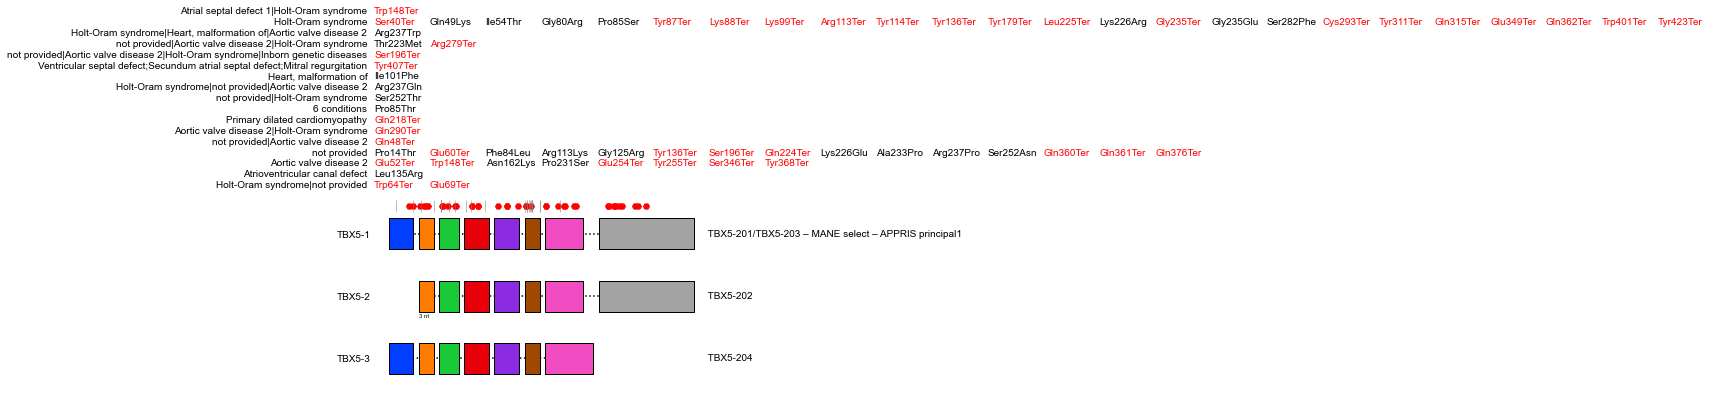

In [83]:
tf = tfs['TBX5']
tf.exon_diagram(show_pathogenic_variants=True)
plt.savefig('/Users/lukelambourne/Desktop/test.svg', bbox_inches='tight')

In [84]:
from pathlib import Path

# TODO: only plot this for TFs with at least one variant
shared_dir = Path('/Users/lukelambourne/Dropbox (Partners HealthCare)/TF_isoforms')
tf_webpage_dir = shared_dir / 'TF_gene_summary_pages'
shared_fig_dir = tf_webpage_dir / 'media'
for tf in tfs.values():
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 0.5 * len(tf.orfs))
    tf.exon_diagram(ax=ax, show_matched_transcripts=True, show_pathogenic_variants=True)
    for fmt in ['.svg']:
        plt.savefig(shared_fig_dir / '{}_clinvar-pathogenic-SNPs_exon-diagram{}'.format(tf.name, fmt),
                    bbox_inches='tight')
    plt.close(plt.gcf())

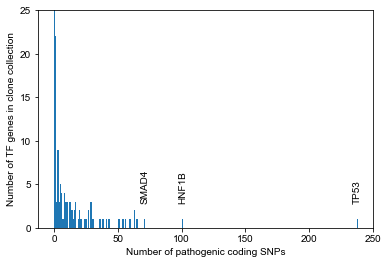

In [46]:
max_n_mut = max(len(x.pathogenic_coding_SNPs) for x in tfs.values())
fig, ax = plt.subplots(1, 1)
ax.hist([len(x.pathogenic_coding_SNPs) for x in tfs.values()],
         range=(-0.5, max_n_mut + 0.5),
        bins=max_n_mut+1)
ax.set_ylim(0, 25)
ax.set_ylabel('Number of TF genes in clone collection')
ax.set_xlabel('Number of pathogenic coding SNPs')

top = [(x.name, len(x.pathogenic_coding_SNPs)) for x in tfs.values() if len(x.pathogenic_coding_SNPs) > 70]
for name, count in top:
    ax.annotate(s=name, xy=(count, 3), rotation=90, ha='center')

fig.savefig('../../figures/n-pathogenic-coding-SNPs-per-gene-in-TFiso1.0_histogram.pdf',
            bbox_inches='tight')

In [63]:
# fraction with at least one
print('{} out of {} with at least one pathogenic coding SNP'.format(
    sum(len(x.pathogenic_coding_SNPs) > 0 for x in tfs.values()),
    len(tfs)))
# table of top
tb = pd.DataFrame(data=[(x.name, len(x.pathogenic_coding_SNPs)) for x in tfs.values()
                        if len(x.pathogenic_coding_SNPs) > 0],
                  columns=['gene', 'count'])
tb = tb.set_index('gene')
tb.sort_values('count', ascending=False).iloc[80:, :]

100 out of 309 with at least one pathogenic coding SNP


,count
gene,
FEZF1,1
CREB3L3,1
SOX30,1
ETV2,1
ELF2,1
NEUROD1,1
TBX15,1
ETV4,1
NPAS2,1


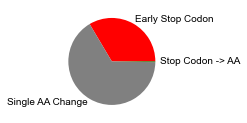

In [80]:
from collections import Counter

def cat(mut):
    if mut.startswith('Ter'):
        return 'Stop Codon -> AA'
    elif mut.endswith('Ter'):
        return 'Early Stop Codon'
    else:
        return 'Single AA Change'

mut_cats = Counter([cat(mut.aa_change) for x in tfs.values() for mut in x.pathogenic_coding_SNPs])
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
ax.pie(mut_cats.values(), labels=mut_cats.keys(), colors=['red', 'grey', 'green'])
fig.savefig('../../figures/mutation-category_pathogenic-coding-SNPs-in-TFiso1.0_pie.pdf',
            bbox_inches='tight')

In [76]:
sum(mut_cats.values())

1822